# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Rebalancing import *
from Git import *

In [3]:
# %run "Git.ipynb".ipynb

In [4]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [7]:

Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [8]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [13]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [15]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [17]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [19]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
# trade_history=pd.read_excel(BytesIO(myfile.content))
trade_history

,Date(UTC),Market,Type,Price,Amount,Total,Fee,Fee Coin
0,2025-08-22 20:15:46,TRXTRY,BUY,14.852000,587.000000,8718.124000,0.000268,BNB
1,2025-08-22 20:14:45,JASMYTRY,SELL,0.682000,12792.000000,8724.144000,0.000269,BNB
2,2025-08-09 00:37:56,BBBNB,SELL,0.000163,116.400000,0.018985,0.000014,BNB
3,2024-09-25 15:25:35,OMUSDT,BUY,1.180300,57.000000,67.277100,0.057000,OM
4,2024-09-25 15:25:35,OMUSDT,BUY,1.180300,34.000000,40.130200,0.034000,OM
...,...,...,...,...,...,...,...,...
77,2024-05-09 22:32:57,TRXEUR,BUY,0.118983,205.828142,25.000000,0.510000,EUR
78,2024-05-09 19:36:50,UMAEUR,BUY,3.803499,6.438808,25.000000,0.510000,EUR
79,2024-05-06 23:27:11,ETHEUR,BUY,2912.268956,0.008407,25.000000,0.510000,EUR
80,2024-05-06 23:15:38,BTCEUR,BUY,59899.712723,0.000409,25.000000,0.510000,EUR


In [ ]:
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [55]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

historical_positions.rename(columns={'TRYUSDT': 'USDTTRY'}, inplace=True)


In [57]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_62472\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [61]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()


In [62]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()

In [75]:
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Average Cost','Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Average Cost']=np.nan

pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100

pnl.sort_values(ascending=False,by='Price in USDT').round(2)


,Average Cost,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,NaN,2187.23,2253.41,1.00,-273.34,339.52,66.18,3.03
BTCUSDT,70306.87,622.27,1033.60,0.46,2.80,411.33,414.13,18.93
TRXUSDT,0.20,216.87,393.57,0.17,-12.30,176.69,164.39,7.52
SOLUSDT,157.06,281.20,356.51,0.16,0.00,75.31,75.31,3.44
ETHUSDT,3654.53,253.39,333.74,0.15,0.00,80.35,80.35,3.67
OMUSDT,1.13,526.32,117.80,0.05,0.00,-408.52,-408.52,-18.68
BNBUSDT,680.95,13.83,18.19,0.01,-10.59,4.36,-6.23,-0.28
PEPEUSDT,0.00,0.00,0.00,0.00,-38.52,-0.00,-38.52,-1.76
RNDRUSDT,11.19,0.00,0.00,0.00,0.00,0.00,0.00,0.00
UMAUSDT,4.10,0.00,0.00,0.00,-5.02,0.00,-5.02,-0.23


In [28]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

129

In [29]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [30]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [31]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [32]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [33]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [34]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [36]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: b7bb97446bb71825ec89733e06228ea6abb54711)
✅ File pushed/updated successfully!


In [37]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [38]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [39]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [40]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 2d7c7190a01505d578f995e5685fb9c06dbf3d0f)
✅ File pushed/updated successfully!


In [41]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [42]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [43]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [44]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [45]:
# pnl_history['Total']

In [46]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [47]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [48]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [49]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)#+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [50]:
pnl_history['Total']

2024-09-23   -260.603192
2024-09-24   -237.099853
2024-09-25   -254.360005
2024-09-26   -168.660788
2024-09-27   -152.141667
                 ...    
2025-08-16     41.554877
2025-08-17     47.741281
2025-08-18     -3.670555
2025-08-19    -77.696716
2025-08-20     -9.940913
Name: Total, Length: 332, dtype: float64

<Axes: >

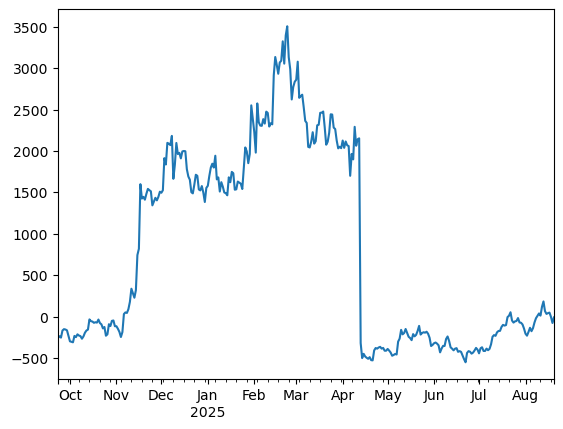

In [51]:
pnl_history['Total'].plot()

In [52]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl[-31:].cumsum()

2025-07-21     16.674338
2025-07-22     58.566044
2025-07-23    -41.019863
2025-07-24    -66.189285
2025-07-25    -51.577973
2025-07-26    -46.653821
2025-07-27    -11.529995
2025-07-28    -64.302994
2025-07-29    -68.038187
2025-07-30    -88.353308
2025-07-31   -138.121275
2025-08-01   -200.606115
2025-08-02   -224.266112
2025-08-03   -179.436893
2025-08-04   -128.996803
2025-08-05   -170.016857
2025-08-06   -133.603468
2025-08-07    -65.164201
2025-08-08    -13.077740
2025-08-09     15.560909
2025-08-10     44.141065
2025-08-11     18.015007
2025-08-12    124.426488
2025-08-13    189.466763
2025-08-14     72.521944
2025-08-15     38.733242
2025-08-16     48.149327
2025-08-17     54.335731
2025-08-18      2.923895
2025-08-19    -71.102266
2025-08-20     -3.346463
Name: Total, dtype: float64

In [53]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-371.01429840649405, -950.5160328166935)

In [54]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [55]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [56]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [57]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [58]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [59]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [60]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

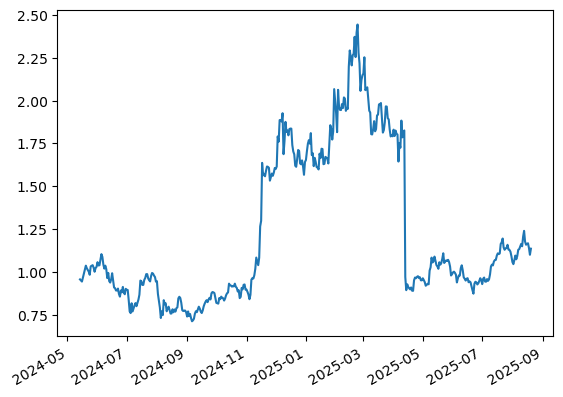

In [61]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

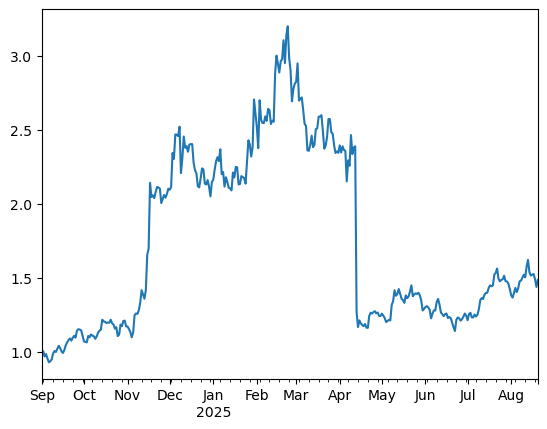

In [62]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [64]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [67]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [68]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [71]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.4063
TRXUSDT,0.2088
WBTCUSDT,0.1422
XRPUSDT,0.0936
BTCUSDT,0.0711
OMUSDT,0.0398
ADAUSDT,0.0382
DOGEUSDT,0.0000
LTCUSDT,0.0000
JASMYUSDT,0.0000


In [72]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.399160
WBTCUSDT,0.246911
TRXUSDT,0.206886
XRPUSDT,0.109223
OMUSDT,0.037820


In [73]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

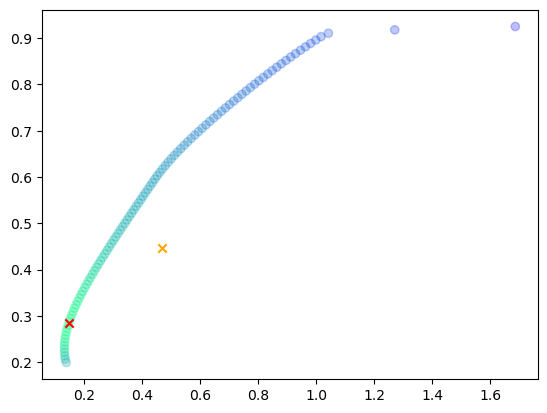

In [74]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [75]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [76]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,994.9277,0.4730,0.0000,0.4730
SOLUSDT,323.4435,0.1538,0.0000,0.1538
ETHUSDT,293.3995,0.1395,0.0000,0.1395
JASMYUSDT,192.6611,0.0916,0.0000,0.0916
TRXUSDT,171.9246,0.0817,0.0289,0.0528
OMUSDT,109.6040,0.0521,0.0051,0.0470
BNBUSDT,17.3422,0.0082,0.0548,-0.0466
BBUSDT,0.0015,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0028,-0.0028
PAXGUSDT,0.0000,0.0000,0.7457,-0.7457


### Current results

In [78]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [79]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.613935
TRXUSDT,0.386065


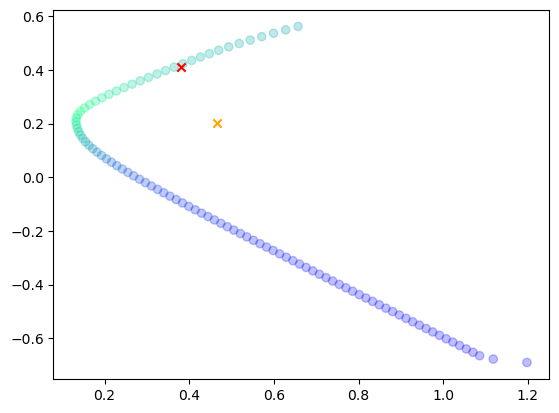

In [80]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [81]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison.round(4)

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,994.9277,0.4730,0.6139,-0.1409
SOLUSDT,323.4435,0.1538,0.0000,0.1538
ETHUSDT,293.3995,0.1395,0.0000,0.1395
JASMYUSDT,192.6611,0.0916,0.0000,0.0916
TRXUSDT,171.9246,0.0817,0.3861,-0.3043
OMUSDT,109.6040,0.0521,0.0000,0.0521
BNBUSDT,17.3422,0.0082,0.0000,0.0082
BBUSDT,0.0015,0.0000,0.0000,0.0000
PEPEUSDT,0.0000,0.0000,0.0000,0.0000


# Risk Reward Analysis

In [83]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [84]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

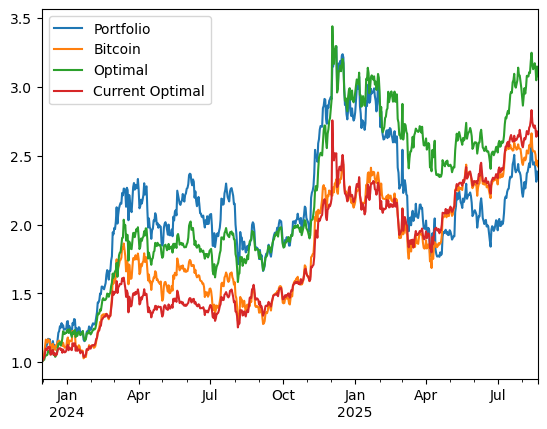

In [85]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [86]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

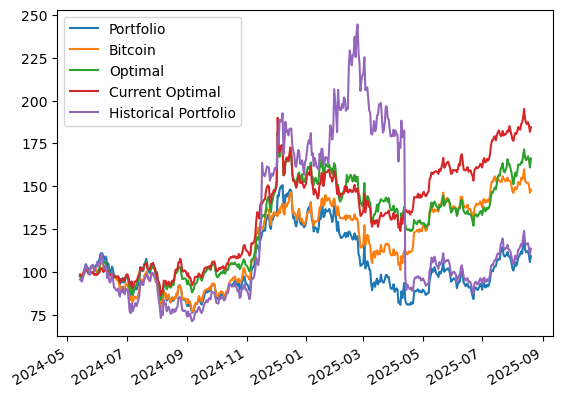

In [87]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


<Axes: >

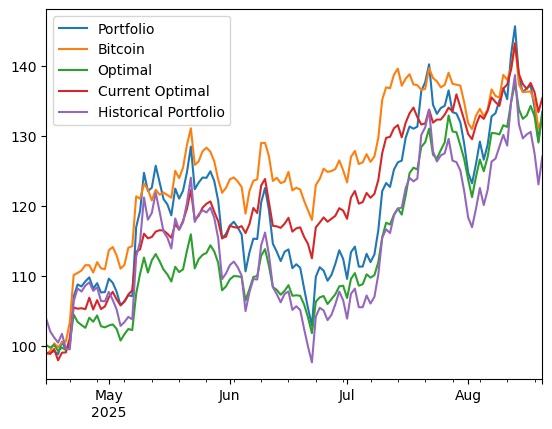

In [88]:
((1+current_perf.loc['2025-04-15':]).cumprod()*100).plot()

## Volatilities

In [90]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.37608
 dtype: float64,
 0.376376773829046)

In [91]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.465608
 dtype: float64,
 0.4656082494833043)

In [92]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.467288
Bitcoin            0.406909
Optimal            0.376377
Current Optimal    0.373280
dtype: float64

In [93]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.5316087690869803

In [94]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-0.5096140216327272

<Axes: >

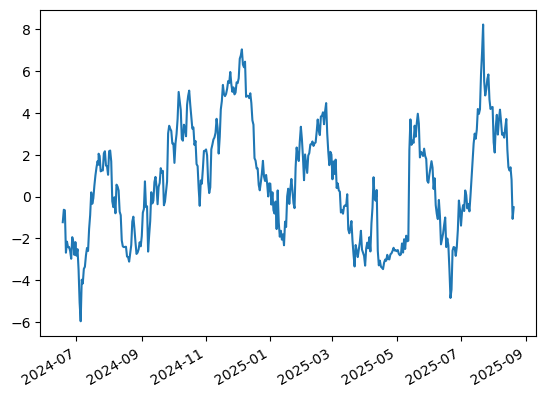

In [95]:
window=30
rolling_sharpe_ratio=current_perf['Historical Portfolio'].rolling(window).mean()*252/(current_perf['Historical Portfolio'].rolling(window).std()*np.sqrt(252))
rolling_sharpe_ratio.plot()

In [96]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.43169805687563123

## Risk Contribution

In [98]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,75.6709,0.3998,0.2182,0.1816
WBTCUSDT,35.3498,0.2069,0.0699,0.1370
TRXUSDT,28.2572,0.1955,0.1031,0.0924
XRPUSDT,17.8951,0.1307,0.0405,0.0901
OMUSDT,-34.9858,0.0672,0.0287,0.0385
Portfolio,122.1872,1.0000,0.4605,0.5395


In [99]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
TRXUSDT,38.818488,0.529341,0.445665,0.083676
BTCUSDT,34.329763,0.470659,0.386983,0.083676
Portfolio,73.148251,1.000000,0.832648,0.167352


In [100]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,26.546733,0.355503,0.154112,0.201392
TRXUSDT,8.125180,0.042212,0.013003,0.029209
ETHUSDT,0.492480,0.156053,0.032928,0.123125
BNBUSDT,0.219378,0.006735,0.000078,0.006658
SOLUSDT,-3.310328,0.197806,0.051503,0.146303
JASMYUSDT,-6.250824,0.160903,0.040955,0.119949
OMUSDT,-7.876894,0.080786,0.035466,0.045320
Portfolio,17.945725,1.000000,0.328045,0.671955


# Value At Risk

## Historical

### Optimal Weights

In [104]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.06401055780362642, -0.0809442139970884)

### Current Weights

In [106]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.0800762559150058, -0.09738063393526483)

In [107]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [108]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.031222
SOLUSDT     -0.012081
ETHUSDT     -0.012272
JASMYUSDT   -0.015602
TRXUSDT     -0.003974
OMUSDT      -0.002870
BNBUSDT     -0.000677
BBUSDT      -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.078699
Name: 2025-03-09 00:00:00, dtype: float64

In [109]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.025702
SOLUSDT     -0.018303
ETHUSDT     -0.014091
JASMYUSDT   -0.012298
TRXUSDT     -0.004254
OMUSDT      -0.018984
BNBUSDT     -0.000636
BBUSDT       0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.094267
dtype: float64

## Parametric

### Optimal Weights

In [112]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.05515656390769122, -0.06831501250326974)

### Current Weights

In [114]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.06823309235399001, -0.08451114839388305)

## Multivariate

### Optimal Weights

In [117]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05187876268130835, -0.060587548132618976)

### Current Weights

In [119]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06755868615184006, -0.07880288130102849)

In [120]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.022812
SOLUSDT     -0.013478
ETHUSDT     -0.010945
JASMYUSDT   -0.011295
TRXUSDT     -0.003294
OMUSDT      -0.005182
BNBUSDT     -0.000461
Portfolio   -0.067466
dtype: float64

In [121]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.022715
SOLUSDT     -0.013579
ETHUSDT     -0.011040
JASMYUSDT   -0.011113
TRXUSDT     -0.003704
OMUSDT      -0.005569
BNBUSDT     -0.000487
Portfolio   -0.068208
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [125]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.053110124926426916, -0.06117992335207265)

### Current Weights

In [127]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06612622129399763, -0.07711292603198422)

In [128]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [131]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05382919583436022, -0.061495214646000856)

### Current Weights

In [133]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06986562707571557, -0.0813416310898046)

In [134]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [137]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.08506666650235009, -0.1037912139808713)

### Current Weights

In [139]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.09074055202843267, -0.11001550270772205)

In [140]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [143]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [144]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05581059755464168, -0.06373298168366158)

### Current Weights

In [146]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.06893309548189376, -0.07914142884565645)

In [147]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [148]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.031226,-0.023571,-0.017767,-0.022812,-0.024809
SOLUSDT,-0.007803,-0.013637,-0.009169,-0.013478,-0.013321
ETHUSDT,-0.003793,-0.010652,-0.007544,-0.010945,-0.010991
JASMYUSDT,-0.005869,-0.011000,-0.008110,-0.011295,-0.011397
TRXUSDT,-0.001042,-0.002544,-0.002501,-0.003294,-0.002837
OMUSDT,-0.007558,-0.005563,-0.003708,-0.005182,-0.005476
BNBUSDT,-0.000053,-0.000449,-0.000351,-0.000461,-0.000491
Portfolio,-0.057344,-0.067415,-0.049149,-0.067466,-0.069322


In [149]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.034379,-0.023750,-0.018273,-0.022715,-0.025427
SOLUSDT,-0.008398,-0.013370,-0.008858,-0.013579,-0.013614
ETHUSDT,-0.003212,-0.010543,-0.007281,-0.011040,-0.010778
JASMYUSDT,-0.003760,-0.010997,-0.007692,-0.011113,-0.011172
TRXUSDT,-0.001655,-0.003208,-0.002515,-0.003704,-0.002871
OMUSDT,-0.006744,-0.006002,-0.004593,-0.005569,-0.005889
BNBUSDT,-0.000013,-0.000457,-0.000368,-0.000487,-0.000473
Portfolio,-0.058161,-0.068327,-0.049580,-0.068208,-0.070224


## VaR Violation

In [151]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-30,-0.030704,-0.040423,-0.034215,0.007324
2023-12-31,-0.030704,-0.040551,-0.032100,-0.001149
2024-01-01,-0.030704,-0.040713,-0.034426,0.015184
2024-01-02,-0.030704,-0.040646,-0.033524,0.005387
2024-01-03,-0.030704,-0.041455,-0.036021,-0.019826
...,...,...,...,...
2025-08-17,-0.027932,-0.040081,-0.037767,0.010344
2025-08-18,-0.027932,-0.040442,-0.038853,-0.010961
2025-08-19,-0.028353,-0.041067,-0.040536,-0.028372
2025-08-20,-0.028353,-0.043274,-0.040953,0.032667


In [152]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.023974,-0.077754,-0.071619,-0.015840
2024-05-29,-0.017454,-0.075728,-0.069127,-0.009074
2024-05-30,-0.017454,-0.063943,-0.059711,0.022175
2024-05-31,-0.017454,-0.062844,-0.057250,0.005199
2024-06-01,-0.017454,-0.061116,-0.057176,0.015214
...,...,...,...,...
2025-08-17,-0.045915,-0.056707,-0.048772,0.002976
2025-08-18,-0.046362,-0.058678,-0.055338,-0.023332
2025-08-19,-0.047989,-0.061437,-0.061893,-0.034951
2025-08-20,-0.047989,-0.062682,-0.059570,0.032056


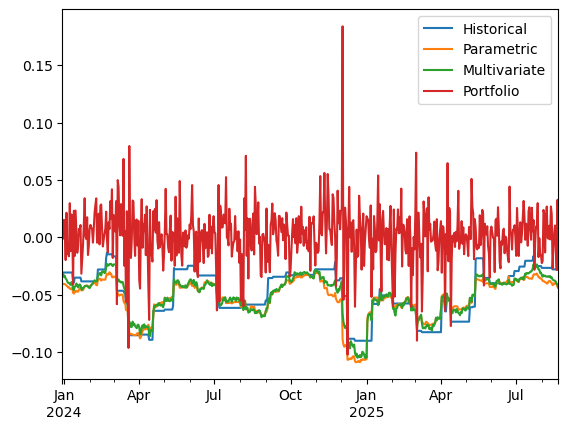

In [153]:
var_data.plot()
plt.show()

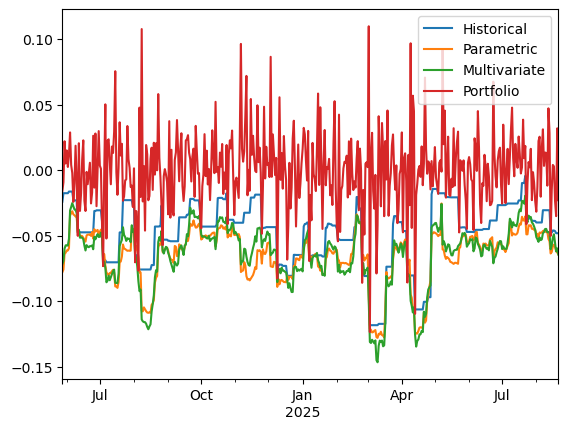

In [154]:
current_var_data.plot()
plt.show()


In [155]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.031614,0.018303,0.016639
Kupiec Stat,4.892392,16.619376,18.790443
P-value,0.026975,0.000046,0.000015


In [156]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.064302,0.017738,0.015521
Kupiec Stat,1.788115,13.007916,15.280111
P-value,0.181156,0.00031,0.000093


# Principal Component Analysis

## Historical PCA

In [159]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.59301215, 0.22550128, 0.07577388, 0.05835184, 0.04736084])

In [160]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

ADAUSDT      0.059562
AVAXUSDT     0.059939
BCHUSDT      0.045500
BNBUSDT      0.026641
BTCUSDT      0.030547
DOGEUSDT     0.062452
ETHUSDT      0.044381
HBARUSDT     0.060035
JASMYUSDT    0.069556
LINKUSDT     0.056205
LTCUSDT      0.042071
OMUSDT       0.066987
PAXGUSDT     0.000514
PEPEUSDT     0.079617
SOLUSDT      0.052733
SUIUSDT      0.058230
TRXUSDT      0.017416
USDCUSDT    -0.000155
WBETHUSDT    0.044385
WBTCUSDT     0.030337
XLMUSDT      0.047240
XRPUSDT      0.045807
Name: PC1, dtype: float64

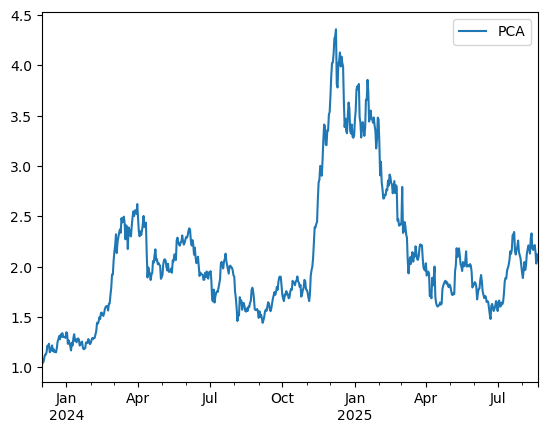

In [161]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

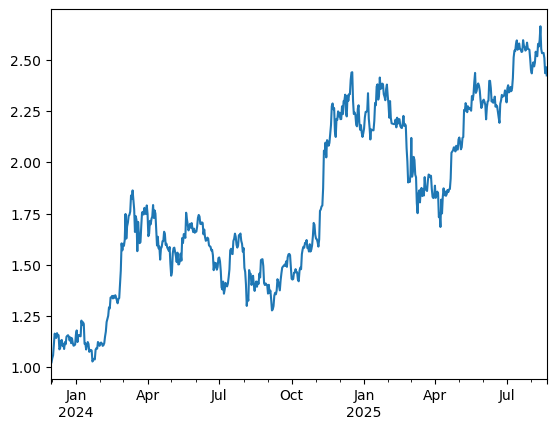

In [162]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [163]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
WBETHUSDT    0.504805
ETHUSDT      0.505843
WBTCUSDT     0.552957
BTCUSDT      0.553649
AVAXUSDT     0.670554
SOLUSDT      0.674852
LINKUSDT     0.694447
DOGEUSDT     0.696473
BNBUSDT      0.711523
LTCUSDT      0.715712
ADAUSDT      0.734211
XRPUSDT      0.769469
BCHUSDT      0.835981
XLMUSDT      0.906099
USDCUSDT     0.952639
PAXGUSDT     0.965371
SUIUSDT      1.073685
TRXUSDT      1.085238
HBARUSDT     1.104355
dtype: float64

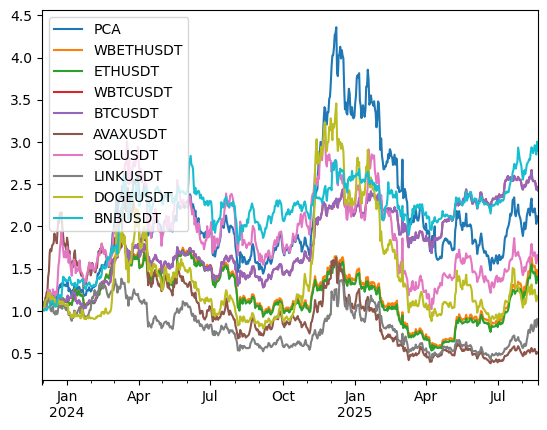

In [164]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

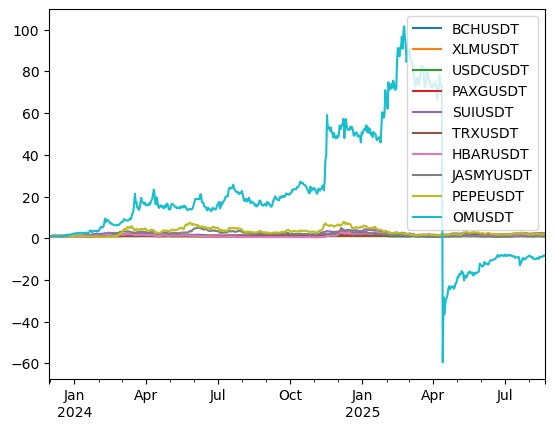

In [165]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [167]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.52555771, 0.30137021, 0.06881054, 0.06300383, 0.04125771])

In [168]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.049646
SOLUSDT      0.093438
ETHUSDT      0.081514
JASMYUSDT    0.141838
TRXUSDT      0.034414
OMUSDT       0.237755
BNBUSDT      0.051518
BBUSDT       0.171122
PEPEUSDT     0.137623
PAXGUSDT     0.001132
Name: PC1, dtype: float64

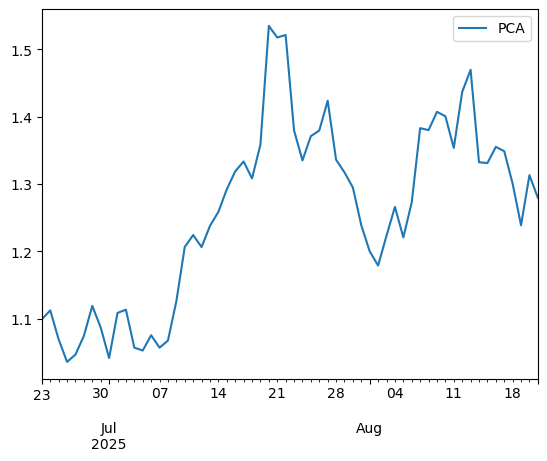

In [169]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA.iloc[-60:]).cumprod().plot()
plt.show()

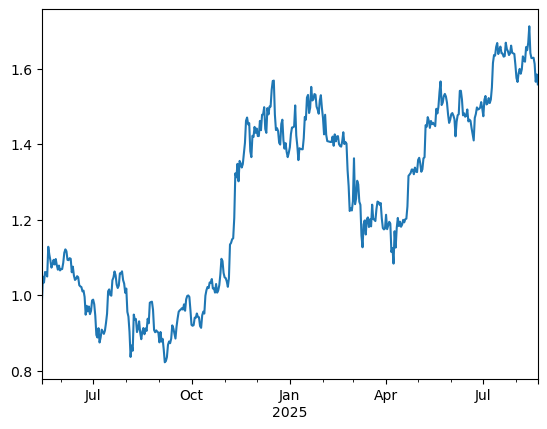

In [170]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [171]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.731013
SOLUSDT      0.769919
BTCUSDT      0.794021
BNBUSDT      0.795664
JASMYUSDT    0.972774
PEPEUSDT     1.007654
PAXGUSDT     1.059303
BBUSDT       1.081665
TRXUSDT      1.176425
dtype: float64

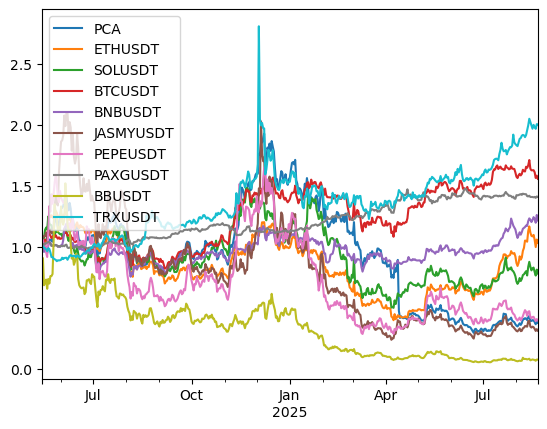

In [172]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [174]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.919503
BBUSDT       1.648414
JASMYUSDT    1.471935
SOLUSDT      1.289562
ETHUSDT      1.098308
BTCUSDT      1.000000
OMUSDT       0.996076
BNBUSDT      0.666354
TRXUSDT      0.332194
PAXGUSDT     0.029224
Name: BTCUSDT, dtype: float64

In [175]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       4.255486
JASMYUSDT    2.433736
PEPEUSDT     2.035220
SOLUSDT      1.990951
ETHUSDT      1.879700
OMUSDT       1.701263
BNBUSDT      1.124761
BTCUSDT      1.000000
TRXUSDT      0.501148
PAXGUSDT     0.091300
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [177]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [178]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
ETHUSDT,0.215456
PEPEUSDT,0.187215
BNBUSDT,0.178145
OMUSDT,0.147822
JASMYUSDT,0.118573
PAXGUSDT,0.088736
TRXUSDT,0.086879
SOLUSDT,0.079370
BBUSDT,0.043298
BTCUSDT,-0.027091


### Regression to PCA

In [180]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.4626961197436041

In [181]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.315884
BNBUSDT      1.125139
PCA          1.000000
ETHUSDT      0.878622
SOLUSDT      0.725276
JASMYUSDT    0.464525
PEPEUSDT     0.459358
BBUSDT       0.368546
TRXUSDT      0.283872
PAXGUSDT     0.246672
OMUSDT       0.156478
dtype: float64

In [182]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.890036
PAXGUSDT     1.684348
BNBUSDT      1.222313
PCA          1.000000
TRXUSDT      0.977935
ETHUSDT      0.885455
SOLUSDT      0.865276
PEPEUSDT     0.742448
JASMYUSDT    0.666107
OMUSDT       0.658168
BBUSDT       0.288958
dtype: float64

### Correlation Matrix

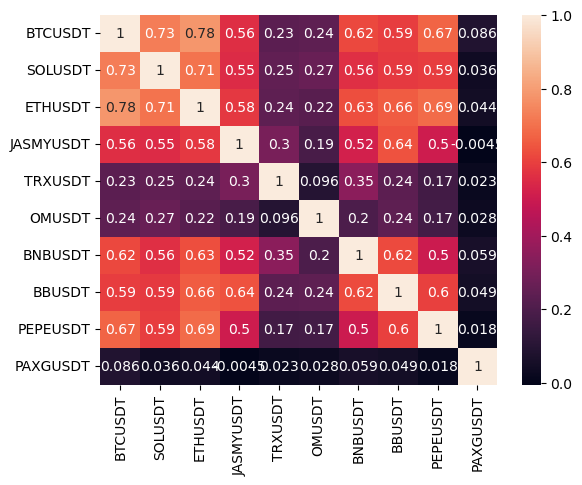

In [184]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

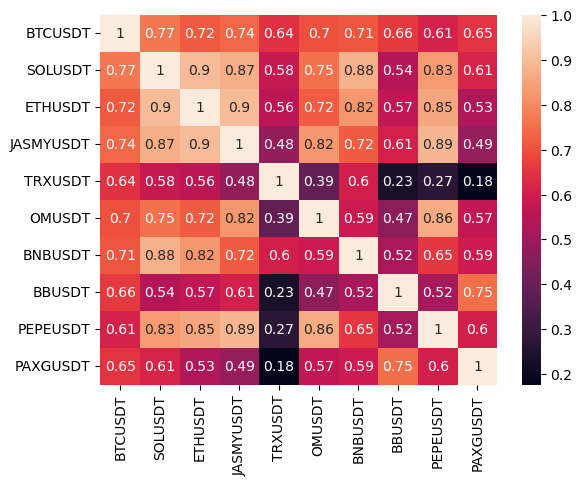

In [185]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [186]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [187]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

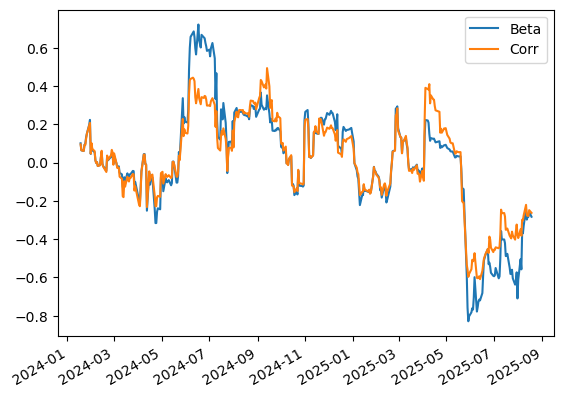

In [188]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [190]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,BTCUSDT,SOLUSDT,ETHUSDT,JASMYUSDT,TRXUSDT,OMUSDT,BNBUSDT,BBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.000000,0.000000,0.000000,0.150876,0.222957,0.626168,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.223616,0.000000,0.000000,0.003604,0.000000,0.772780
2024-07-22,0.260704,0.086231,0.000000,0.000000,0.238042,0.019283,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.453780,0.000000,0.000000,0.000000,0.000000,0.546220
2024-09-02,0.000000,0.000000,0.000000,0.000000,0.564814,0.435186,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.000000,0.000000,0.166022,0.000000,0.526887,0.176734,0.000000,0.000000,0.130357,0.000000


In [191]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

In [192]:
for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit[0]]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,ADAUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BTCUSDT,DOGEUSDT,ETHUSDT,HBARUSDT,JASMYUSDT,LINKUSDT,...,PAXGUSDT,PEPEUSDT,SOLUSDT,SUIUSDT,TRXUSDT,USDCUSDT,WBETHUSDT,WBTCUSDT,XLMUSDT,XRPUSDT
2025-01-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.761799,0.0,0.000000,0.111228,0.000000,0.0,0.000000,0.000000,0.000000,0.126972
2025-02-12,0.000000,0.000000,0.000000,0.012192,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.956052,0.0,0.000476,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2025-03-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.909521,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2025-04-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000259,0.000000,...,0.661326,0.0,0.000000,0.000000,0.338416,0.0,0.000000,0.000000,0.000000,0.000000
2025-05-13,0.000000,0.000000,0.000000,0.000000,0.034044,0.0,0.013515,0.0,0.000000,0.000000,...,0.475024,0.0,0.048527,0.062361,0.000000,0.0,0.116095,0.169228,0.000000,0.000000
2025-06-12,0.000000,0.000000,0.114887,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.830482,0.0,0.000000,0.000000,0.054631,0.0,0.000000,0.000000,0.000000,0.000000
2025-07-12,0.000000,0.000000,0.183448,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.685043,0.0,0.000000,0.000000,0.131508,0.000000
2025-08-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.060602,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.495196,0.0,0.320830,0.000000,0.000000,0.000000
2025-08-21,0.057083,0.010851,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.932066,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [193]:
rolling_optimization.iloc[-2].sort_values(ascending=False)[:6]

TRXUSDT      0.495196
WBETHUSDT    0.320830
LTCUSDT      0.123373
ETHUSDT      0.060602
ADAUSDT      0.000000
PAXGUSDT     0.000000
Name: 2025-08-11 00:00:00, dtype: float64

<Axes: >

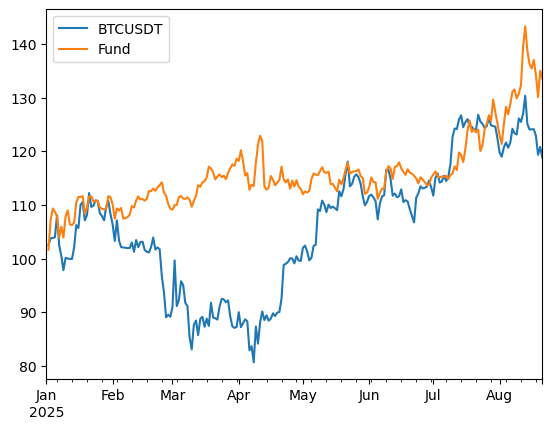

In [194]:
q=rebalanced_dynamic_quantities(data[returns_to_use.columns],rolling_optimization)
ptf=q*data[returns_to_use.columns]
comparison=pd.DataFrame()
comparison['BTCUSDT']=data['BTCUSDT']
comparison['Fund']=ptf.sum(axis=1)
((1+comparison.loc['2025'].pct_change()).cumprod()*100).plot()

In [195]:
(ptf-rebalanced_book_cost(data[returns_to_use.columns],q)).iloc[-1].sort_values(ascending=False)

PAXGUSDT     70.259116
SUIUSDT      67.254467
XRPUSDT      39.537859
TRXUSDT      36.826445
BCHUSDT      12.769523
XLMUSDT       3.338246
WBTCUSDT      0.690684
BTCUSDT       0.135659
JASMYUSDT     0.020587
USDCUSDT      0.000000
PEPEUSDT      0.000000
ADAUSDT       0.000000
AVAXUSDT      0.000000
LINKUSDT      0.000000
HBARUSDT      0.000000
DOGEUSDT      0.000000
WBETHUSDT    -0.008450
ETHUSDT      -0.018193
BNBUSDT      -0.481832
SOLUSDT      -2.234563
LTCUSDT      -5.119495
OMUSDT      -18.970496
Name: 2025-08-21 00:00:00, dtype: float64

In [196]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
